#Modelo para predicción de fallos en bomba de agua

A partir de un set de datos temporales de sensores para un bomba de agua, el cual está etiquetado con los diferentes modos de operación (funcionamiento, averiado, en reparación) se pretende generar un modelo que sea capaz de predecir si la bomba de agua fallará en un período de tiempo determinado. Para ello, se utilizará un modelo basado en redes neuronales LSTM. Realizando un análisis de la información, se puede concluir que las variables leidas por los sensores son las siguientes:

* SENSOR_00 – Motor Casing Vibration
*SENSOR_01 – Motor Frequency A
*SENSOR_02 – Motor Frequency B
*SENSOR_03 – Motor Frequency C
*SENSOR_04 – Motor Speed
*SENSOR_05 – Motor Current
*SENSOR_06 – Motor Active Power
*SENSOR_07 – Motor Apparent Power
*SENSOR_08 – Motor Reactive Power
*SENSOR_09 – Motor Shaft Power
*SENSOR_10 – Motor Phase Current A
*SENSOR_11 – Motor Phase Current B
*SENSOR_12 – Motor Phase Current C
*SENSOR_13 – Motor Coupling Vibration
*SENSOR_14 – Motor Phase Voltage AB
*SENSOR_16 – Motor Phase Voltage BC
*SENSOR_17 – Motor Phase Voltage CA
*SENSOR_18 – Pump Casing Vibration
*SENSOR_19 – Pump Stage 1 Impeller Speed
*SENSOR_20 – Pump Stage 1 Impeller Speed
*SENSOR_21 – Pump Stage 1 Impeller Speed
*SENSOR_22 – Pump Stage 1 Impeller Speed
*SENSOR_23 – Pump Stage 1 Impeller Speed
*SENSOR_24 – Pump Stage 1 Impeller Speed
*SENSOR_25 – Pump Stage 2 Impeller Speed
*SENSOR_26 – Pump Stage 2 Impeller Speed
*SENSOR_27 – Pump Stage 2 Impeller Speed
*SENSOR_28 – Pump Stage 2 Impeller Speed
*SENSOR_29 – Pump Stage 2 Impeller Speed
*SENSOR_30 – Pump Stage 2 Impeller Speed
*SENSOR_31 – Pump Stage 2 Impeller Speed
*SENSOR_32 – Pump Stage 2 Impeller Speed
*SENSOR_33 – Pump Stage 2 Impeller Speed
*SENSOR_34 – Pump Inlet Flow
*SENSOR_35 – Pump Discharge Flow
*SENSOR_36 – Pump UNKNOWN
*SENSOR_37 – Pump Lube Oil Overhead Reservoir Level
*SENSOR_38 – Pump Lube Oil Return Temp
*SENSOR_39 – Pump Lube Oil Supply Temp
*SENSOR_40 – Pump Thrust Bearing Active Temp
*SENSOR_41 – Motor Non Drive End Radial Bearing Temp 1
*SENSOR_42 – Motor Non Drive End Radial Bearing Temp 2
*SENSOR_43 – Pump Thrust Bearing Inactive Temp
*SENSOR_44 – Pump Drive End Radial Bearing Temp 1
*SENSOR_45 – Pump non Drive End Radial Bearing Temp 1
*SENSOR_46 – Pump Non Drive End Radial Bearing Temp 2
*SENSOR_47 – Pump Drive End Radial Bearing Temp 2
*SENSOR_48 – Pump Inlet Pressure
*SENSOR_49 – Pump Temp Unknown
*SENSOR_50 – Pump Discharge Pressure 1
*SENSOR_51 – Pump Discharge Pressure 2
*Pump Status

##Preparación de los datos

En primer lugar, evaluaremos el conjunto de datos y realizaremos el preprocesamiento necesario para garantizar la calidad de la información con la que se procederá a entrenar el modelo.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import os
import math
import random
%pip install scikit-plot
import scikitplot as skplt
%pip install tensorflow-addons
import tensorflow_addons as tfa
import pickle as pk


from sklearn.metrics import precision_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.4 MB/s eta 0:00:00
2.12.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
sensor_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/sensor.csv')
sensor_data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


En primer lugar debemos evaluar la completitud del dataset, por lo que vamos a comprobar los valores nulos que incluye

In [ ]:
#Convertimos en sello temporal en el indice del conjunto de datos.
sensor_data.timestamp = pd.to_datetime(sensor_data.timestamp)
sensor_data.index = sensor_data['timestamp']
sensor_data.drop(['timestamp'], inplace = True, axis =1)


In [ ]:
sensor_data.head()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [ ]:
sensor_data.isna().sum()

Unnamed: 0             0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


Vemos que tenemos muchos valores vacios dentro del dataset. Para no comprometer la calidad de los datos, vamos a eliminar del dataset todos los sensores que tengan más de un 1% de valores vacios

In [ ]:
thresholdValue = sensor_data.shape[0]*0.01
l=['Unnamed: 0']
for i in sensor_data.isnull().sum().index:
    #print (df.isnull().sum()[i], end=" ")
    if (sensor_data.isnull().sum()[i]>thresholdValue):
        l.append(i)
l
#Almacenamos las columnas que no han participado en el entrenamiento para que no sean consideradas al aplicar el modelo
pk.dump(l, open("/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/drop_columns.pkl", "wb"))


In [ ]:
df = sensor_data.drop(labels=l, axis=1)
df.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'machine_status'],
      dtype='object')

Una vez eliminados los elementos con gran cantidad de datos vacios, procedemos rellenando para el resto de variables lo valores vacios. Para ello, al ser una serie temporal con intervalos de 10 segundos, propagaremos el último valor a la siguiente variable

In [ ]:
df.fillna(method='ffill', inplace=True)

Comrpobamos a continuación cual es la distribución de los estados de la bomba

In [ ]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

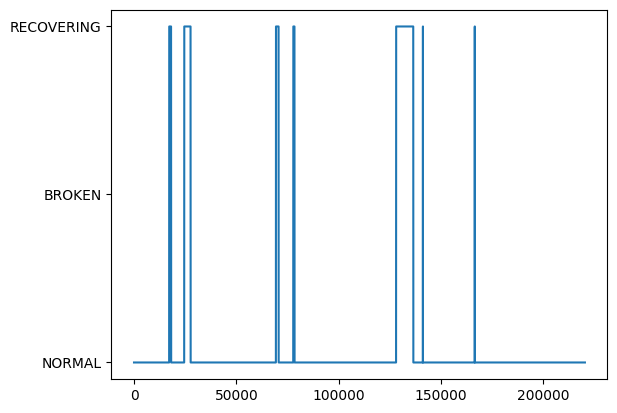

In [ ]:
plt.plot(df['machine_status'])

Debida la distribución del datasets, será muy dificil que el sistema sea capaz de predecir con fiabilidad los estados de averiado de la bomba, ya que tenemos muy pocos datos con esta etiqueta. Sin embargo, evaluando el gráfico de estas, y por lo que nos dice la lógica, los estados de recuperación siempre vendrán precedidos de un estado de rotura, por lo que podemos orientar la solución a predecir únicamente los valores de funcionamiento normal y funcionamiento en recuperación/rotura, ya que si el sistema indica que el un período de tiempo en el que hacemos la predicciónobtenemos un funcionamiento en recuperación, habremos pasado por una rotura.

Dadas las variables medidas por los sensores, podemos intuir que habrá variables dependientes entre ellas (como pueden ser las corrientes y voltajes de las diferentes fases, o las potencias). Vamos a revisar la distribución de valores que presentan estos sensores

In [ ]:
df.plot(subplots=True, sharex = True, figsize = (20,50))

Output hidden; open in https://colab.research.google.com to view.

<Axes: >

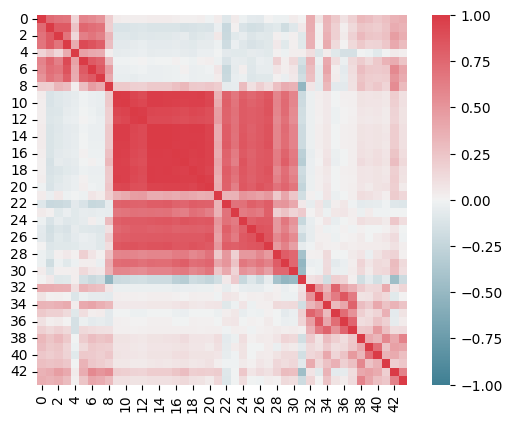

In [ ]:
corr = df.drop(columns=['machine_status']).corr().values
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True)

##Reducción de dimensionalidad

Como indicamos anteriormente, hemos comprobado que tenemos variables relacionadas entre ellas, por lo que será útil para el entrenamiento del modelo que hagamos una reducción de la dimensionalidad. Para ello, tenemos la opción de emplear el algoritmo PCA (Principal Component Analysis), o hacer un algoritmo de clustering y seleccionar las variables que estén más cercanas a los centroides del cluster al que pertenecen. La ventaja del algoritmo de clustering es que sabremos que variables estamos seleccionando, mientra que al aplicar PCA las varibles resultantes serán un compuesto de las anteriores, por lo que se pierde la trazabilidad y tendremos que aplicar el mismo modelo a los datos reales que empleemos para realizar las predicciones.
Debido a que el modelo de ML empleado será una red neuronal LSTM, que ya eliminaría la trazabilidad de los datos, optamos por emplear PCA como modelo para realizar una reducción de la dimensionalidad.

En primer lugar, debemos normalizar las variables para evitar problemas en el entrenamiento

In [ ]:
from sklearn.preprocessing import StandardScaler

#standar scaler standarizes features by removing the mean and dividing by variance, achiving 0 mean and 1 variance for all features in the datasets

scaled_df = df.drop('machine_status',axis=1)
col_names=scaled_df.columns

#scaling
scaler=StandardScaler()
scaler.fit(scaled_df)

#Almacenamos el scaler para poder utilizar en la aplicación del modelo de ML
pk.dump(scaler, open("/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/scaler.pkl","wb"))
scaled_df = scaler.transform(scaled_df)
scaled_df =  pd.DataFrame(scaled_df,columns=col_names)
scaled_df.index = df.index
scaled_df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,-0.152986,0.639354,1.057648,0.303460,0.177150,-0.350762,0.429364,0.195856,-0.782025,0.377352,...,0.080907,-0.553936,-0.358937,-0.176765,-0.260475,1.759657,0.185929,-0.588581,0.086320,0.553107
2018-04-01 00:01:00,-0.152986,0.639354,1.057648,0.303460,0.177150,-0.350762,0.429364,0.195856,-0.782025,0.377352,...,0.080907,-0.553936,-0.358937,-0.176765,-0.260475,1.759657,0.185929,-0.588581,0.086320,0.553107
2018-04-01 00:02:00,-0.074132,0.639354,1.093535,0.334797,0.008734,-0.297815,0.479375,0.291933,-0.778096,0.388598,...,0.032164,-0.619878,-0.358937,-0.200346,-0.285471,1.737116,0.204429,-0.588581,0.061692,0.522877
2018-04-01 00:03:00,-0.152986,0.627520,1.093534,0.260070,0.207740,-0.238946,0.516046,0.250732,-0.796794,0.387727,...,0.154020,-0.619878,-0.384321,-0.271086,-0.310467,1.692034,0.204429,-0.588581,0.061692,0.507762
2018-04-01 00:04:00,-0.139845,0.639354,1.093534,0.317923,0.184619,-0.163737,0.547209,0.278396,-0.781666,0.380159,...,0.373362,-0.553936,-0.384321,-0.223925,-0.335463,1.714575,0.241429,-0.533159,0.089839,0.492648


In [ ]:
scaled_df.describe()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,...,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05,2.203200e+05
mean,2.299331e-15,4.551189e-16,5.263280e-15,-8.091002e-16,-1.562214e-16,7.172508e-16,2.394276e-16,9.019816e-16,-2.559399e-16,-4.540869e-17,...,1.032016e-16,1.139345e-15,2.745161e-16,-1.702826e-16,-5.242639e-16,-2.518118e-16,1.126961e-15,-9.631286e-16,-2.146592e-16,2.229154e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.441227e+01,-4.828443e+00,-5.006965e+00,-4.081218e+00,-4.242232e+00,-3.428772e+00,-3.210253e+00,-2.880603e+00,-1.025643e+00,-3.042367e+00,...,-2.124693e+00,-1.839810e+00,-1.298159e+00,-1.756631e+00,-1.460291e+00,-1.305863e+00,-1.386582e+00,-1.641579e+00,-1.514471e+00,-1.593183e+00
25%,-3.895456e-01,-1.299246e-01,-3.777625e-01,2.496240e-01,-1.975963e-01,-6.323804e-02,-2.344569e-01,-4.460781e-02,-8.027219e-01,3.643531e-01,...,-5.161892e-01,-3.561091e-01,-2.573994e-01,-3.889860e-01,-5.104364e-01,-4.944024e-01,-4.800761e-01,-5.054490e-01,-8.143446e-01,-4.898089e-01
50%,1.624277e-01,2.132920e-01,1.964022e-01,2.914071e-01,1.260943e-01,2.332971e-01,2.638827e-01,3.341305e-01,-6.010686e-01,3.820452e-01,...,-1.140632e-01,-5.936864e-02,-2.893998e-02,-8.244469e-02,-1.854859e-01,-2.239150e-01,-2.025741e-01,-2.006337e-01,-1.564374e-01,-2.328587e-01
75%,5.698340e-01,5.210029e-01,6.449691e-01,3.259583e-01,4.344776e-01,4.956437e-01,5.926436e-01,5.737718e-01,8.376151e-01,3.899152e-01,...,4.221046e-01,3.033131e-01,1.487504e-01,2.476761e-01,2.144531e-01,1.367344e-01,2.044285e-01,2.150238e-01,6.984907e-01,1.903533e-01
max,2.764583e+00,1.408636e+00,1.847128e+00,1.453300e+00,1.537773e+00,2.863843e+00,1.384815e+00,1.568410e+00,3.493236e+00,1.087725e+00,...,2.077212e+01,4.873790e+01,3.302152e+01,3.302398e+01,8.270186e+01,2.159537e+01,2.061006e+01,2.482193e+01,4.994241e+00,2.127538e+01


A continuación, vamos a realizar una reducción de la dimensionalidad empleando PCA. El modelo de PCA se almacenará para su posterior uso en la aplicación de predicción

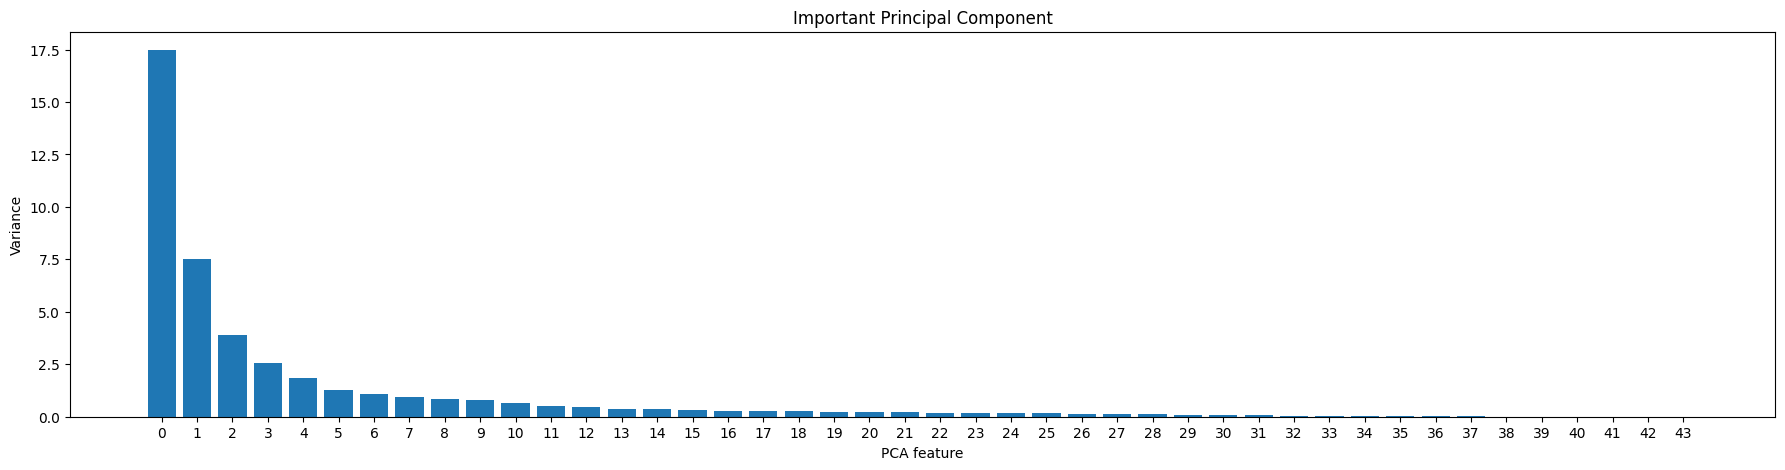

In [ ]:
pca = PCA()
pca.fit(scaled_df)

#Vamos a realizar un plot de las componentes principales

features = range(pca.n_components_)
_=plt.figure(figsize=(22,5))
_=plt.bar(features,pca.explained_variance_)
_=plt.xlabel('PCA feature')
_=plt.ylabel('Variance')
_=plt.xticks(features)
_=plt.title('Important Principal Component')
plt.show()

Viendo la varianza de las diferentes componentes, vamos a considerar una reducción hasta 15 componentes y trabajaremos con esos datos para entrenar el modelo de ML

In [ ]:
pca = PCA(n_components=15)
pca= pca.fit(scaled_df)
pk.dump(pca, open("/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/pca.pkl","wb"))
pComponents = pca.transform(scaled_df)
principal_df = pd.DataFrame(data = pComponents,columns=['pca1','pca2', 'pca3','pca4','pca5', 'pca6','pca7','pca8', 'pca9','pca10','pca11', 'pca12','pca13','pca14', 'pca15',])
principal_df.index = scaled_df.index
principal_df['machine_status'] = df['machine_status']
principal_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,machine_status
timestamp,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,-0.053514,0.378548,-0.592952,-0.873470,2.238872,-1.014905,1.158803,-0.735655,0.632480,-0.339580,0.290100,-0.256010,-0.106103,-0.151199,-0.149079,NORMAL
2018-04-01 00:01:00,-0.053514,0.378548,-0.592952,-0.873470,2.238872,-1.014905,1.158803,-0.735655,0.632480,-0.339580,0.290100,-0.256010,-0.106103,-0.151199,-0.149079,NORMAL
2018-04-01 00:02:00,-0.193356,0.426984,-0.602348,-0.989812,2.339502,-1.065591,0.983901,-0.684924,0.440264,-0.357572,0.208078,-0.175343,-0.079404,-0.175419,-0.160606,NORMAL
2018-04-01 00:03:00,-0.195192,0.405959,-0.598346,-1.091316,2.319772,-1.092526,0.938085,-0.442825,0.518864,-0.342446,0.233638,-0.236832,0.009528,-0.228312,-0.298294,NORMAL
2018-04-01 00:04:00,-0.151021,0.546812,-0.491018,-1.145205,2.235228,-1.087800,1.196590,-0.650606,0.566017,-0.213221,0.146292,-0.171502,0.032769,-0.185236,-0.461269,NORMAL


##Modelo Predictivo

Como hemos indicado antes, para realizar la predicción emplearemos un modelo de redes neuronales LSTM, ya que la capacidad de memoria que contienen este modelo será de gran utilidad al evaluar esta serie temporal, para la cual los fallos probablemente esten ampliamente relacionados con los valores previos de las variables internas del sistema, que serán recogidas por los sensores. Sin embargo, el datasets con el contamos está muy desbalanceado, por lo que será necesario emplear metricas en el entrenamiento que penalicen los estados con menor número de situaciones incorrectamente predichos.

<ipython-input-14-e4efb5708f28>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  principal_df.target = principal_df['machine_status']


Class 0: 205836
Class 1: 14477
Proportion: 14.22 : 1


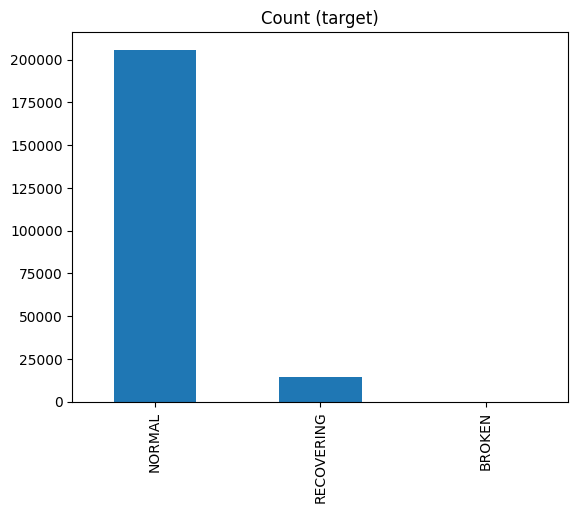

In [ ]:
principal_df.target = principal_df['machine_status']
target_count = principal_df.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names +=[('pca%d(t-%d)' %(j+1, i)) for j in range (n_vars)]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names +=[('pca%d(t)' %(j+1)) for j in range (n_vars)]
        else:
            names +=[('pca%d(t+%d)' %(j+1, i)) for j in range (n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns=names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
#Debido a lo mal balanceado que se encuentra el modelo, y a que como hemos comprobado las situaciones de recuperación siempre se producen posteriores a las de rotura, vamos a considerar la prediccion de ambas situaciones como una sola

principal_df['machine_status'].replace(to_replace={'NORMAL': 1.0, 'RECOVERING': 0.0, 'BROKEN': 0.0}, inplace=True)

feat = principal_df.columns.drop('machine_status').tolist()
features = feat

target_cols = ['machine_status']
features_cols = features

X = principal_df[features]
y = principal_df[target_cols]

In [ ]:
Lag=10 # How many steps to look into the future
data_shift=series_to_supervised(X, n_in=Lag, n_out=Lag)
remove_list_1 =['pca'+str(n)+'(t)' for n in range(1,len(X.columns)+1)] #now remove all non shifted elements again. so we retreive elements and shifted target
remove_list_2 =['pca'+str(n)+'(t+'+ str(i)+')' for n in range(1,len(X.columns)+1) for i in range(1,Lag)]

data_y=y.shift(Lag+Lag -1).dropna()
data_x=data_shift.drop(remove_list_1+remove_list_2, axis=1)



In [ ]:
data_x.head()

,pca1(t-10),pca2(t-10),pca3(t-10),pca4(t-10),pca5(t-10),pca6(t-10),pca7(t-10),pca8(t-10),pca9(t-10),pca10(t-10),...,pca6(t-1),pca7(t-1),pca8(t-1),pca9(t-1),pca10(t-1),pca11(t-1),pca12(t-1),pca13(t-1),pca14(t-1),pca15(t-1)
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:10:00,-0.053514,0.378548,-0.592952,-0.873470,2.238872,-1.014896,1.158787,-0.735686,0.632549,-0.339402,...,-1.092317,0.725974,-0.830017,0.666272,0.015370,0.136084,-0.065370,-0.226566,-0.116776,-0.397957
2018-04-01 00:11:00,-0.053514,0.378548,-0.592952,-0.873470,2.238872,-1.014896,1.158787,-0.735686,0.632549,-0.339402,...,-1.109320,0.584693,-0.756271,0.685644,0.058160,0.165867,-0.089872,-0.249382,0.092069,-0.427493
2018-04-01 00:12:00,-0.193356,0.426984,-0.602348,-0.989812,2.339503,-1.065583,0.983899,-0.684975,0.440354,-0.357348,...,-1.174119,0.491739,-0.782675,0.615186,0.120117,0.268297,-0.145376,-0.251205,0.004775,-0.492416
2018-04-01 00:13:00,-0.195192,0.405959,-0.598346,-1.091316,2.319774,-1.092516,0.938096,-0.442907,0.518991,-0.342131,...,-1.147167,0.692419,-0.887319,0.722991,0.193367,0.366940,-0.205922,-0.194491,0.005454,-0.494097
2018-04-01 00:14:00,-0.151021,0.546812,-0.491018,-1.145205,2.235230,-1.087793,1.196598,-0.650661,0.566119,-0.212964,...,-1.107863,0.533633,-0.808923,0.623141,0.149242,0.369069,-0.132247,-0.301995,0.179159,-0.406713


In [ ]:
# Train test split
X_train = data_x.iloc[0:110000, :]
X_test = data_x.iloc[110000:140000 ,:]
X_val= data_x.iloc[140000:: ,:]

y_train = data_y.iloc[0:110000]
y_test= data_y.iloc[110000:140000]
y_val = data_y.iloc[140000::]

In [ ]:
# reformat the input for lstm
lstm_x_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
lstm_x_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
lstm_x_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [ ]:

# define lstm model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(250, input_shape=(lstm_x_train.shape[1:]), return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# run the model and capture the results
history_lstm = lstm_model.fit(lstm_x_train, y_train,epochs=100, validation_data=(lstm_x_val, y_val), batch_size=1024, shuffle=False,callbacks=[stop_early])
y_predict_lstm = lstm_model.predict(lstm_x_test)


Epoch 1/100
108/108 [==============================] - 19s 137ms/step - loss: 0.2082 - val_loss: 0.1157
Epoch 2/100
108/108 [==============================] - 13s 124ms/step - loss: 0.0444 - val_loss: 0.1738
Epoch 3/100
108/108 [==============================] - 14s 131ms/step - loss: 0.0374 - val_loss: 0.1082
Epoch 4/100
108/108 [==============================] - 15s 140ms/step - loss: 0.0344 - val_loss: 0.1066
Epoch 5/100
108/108 [==============================] - 13s 124ms/step - loss: 0.0287 - val_loss: 0.1253
Epoch 6/100
108/108 [==============================] - 13s 118ms/step - loss: 0.0272 - val_loss: 0.1067
Epoch 7/100
108/108 [==============================] - 12s 113ms/step - loss: 0.0229 - val_loss: 0.1198
Epoch 8/100
108/108 [==============================] - 13s 121ms/step - loss: 0.0180 - val_loss: 0.1310
Epoch 9/100
108/108 [==============================] - 13s 125ms/step - loss: 0.0143 - val_loss: 0.1292
Epoch 10/100
108/108 [==============================] - 13s 125m

In [ ]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 250)            401000    
                                                                 
 dropout_15 (Dropout)        (None, 1, 250)            0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               140400    
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
 dropout_17 (Dropout)        (None, 10)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

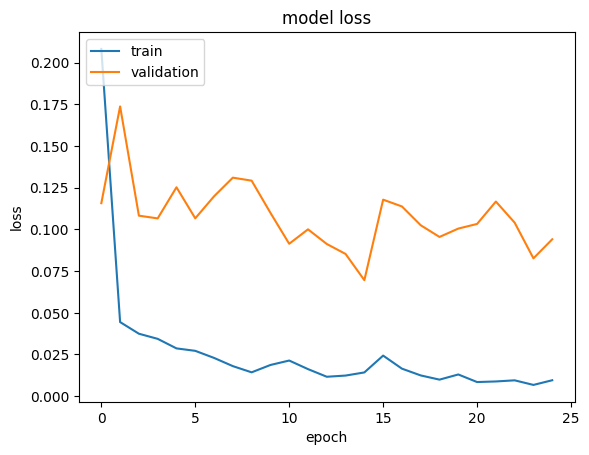

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def assign_classes(y_pred_):
    y_pred = y_pred_.copy()
    y_pred[y_pred<1/2] = 0 # BROKEN
    y_pred[y_pred>=1/2] = 1 # NORMAL
    return y_pred

In [ ]:
y_hat_pred = assign_classes(y_predict_lstm)

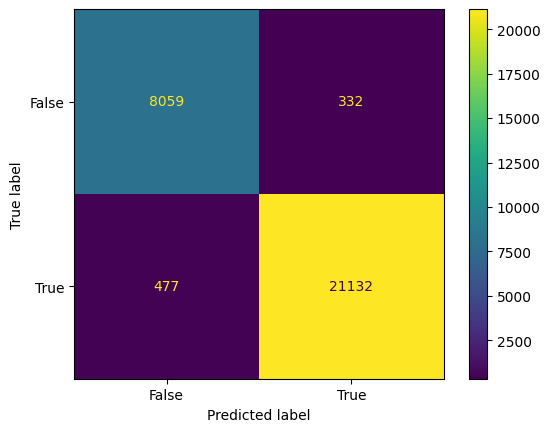

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_hat_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
recall = metrics.recall_score(y_test, y_hat_pred)
recall

0.9779258642232403

In [ ]:
precision = metrics.precision_score(y_test, y_hat_pred)
precision

0.9845322400298173

In [ ]:
f1 = metrics.f1_score(y_test, y_hat_pred)
f1

0.9812179323474103

In [ ]:
lstm_model.save("/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/lstm_model.keras")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Documentos/Water_Pump Failiure detection/lstm_model.keras')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 250)            401000    
                                                                 
 dropout (Dropout)           (None, 1, 250)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               140400    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [ ]:
y_predict = model.predict(lstm_x_test[0:1,:,:])
y_hat_pred = assign_classes(y_predict)

1/1 [==============================] - 8s 8s/step


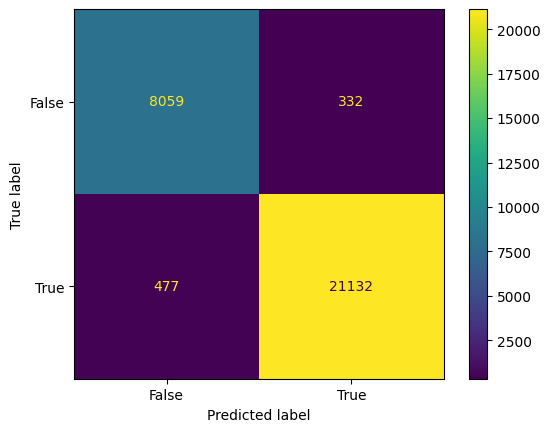

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_hat_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
test = lstm_x_val[1:10,:,:]
predict = model.predict(test)

1/1 [==============================] - 0s 42ms/step
